In [72]:
import cv2 as cv
import io
import matplotlib.pyplot as plt
from skimage.exposure import  equalize_hist
from skimage.morphology import dilation, erosion, area_closing, area_opening
import numpy as np
from skimage.transform import rescale, resize, downscale_local_mean
import joblib

import numpy as np
from numpy import logical_and as land
from numpy import logical_not as lnot
from skimage.feature import canny
from skimage.transform import rescale, ProjectiveTransform, warp
from skimage.morphology import dilation, disk
from skimage.util import img_as_ubyte
import tqdm

In [75]:
def extractpainting (img,mask):
    implt= cv.cvtColor(im, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    blur = cv.blur(gray,(5,5))
    threshad = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, 
                                          cv.THRESH_BINARY, 199, 5) 
    outer=cv.bitwise_not(threshad,threshad)
    outer_erode= erosion(outer)
    areaArray = []
    count = 0
    ids=[]
    contours, _ = cv.findContours(outer_erode, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for i, c in enumerate(contours):
        area = cv.contourArea(c)
        areaArray.append(area)
        if(area>gray.shape[1]*100): #3,33: #100000 #train3333: 500000 #*100
            ids.append(i)
            count+=1    #number of detected contours
    mi=1e10
    ids=np.array(ids)
    if(len(ids)>1):
        for i in ids:
            if areaArray[i]<mi:
                mi=areaArray[i]
                res=i
    else:
        res=ids[0]
    def order_points(pts):
        rect = np.zeros((4, 2), dtype = "float32")
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        # return the ordered coordinates (tr,tl,br,bl)
        return rect
    def four_point_transform(image, points):
        rect = order_points(points)
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))


        dst = np.array([[0, 0],
        [0, maxWidth - 1],
        [ maxHeight - 1,maxWidth - 1],
        [ maxHeight - 1,0]], dtype = "float32")

        M = cv.getPerspectiveTransform(rect, dst)
        warped = cv.warpPerspective(image, M, (maxHeight,maxWidth))
        return warped
    out= np.zeros((gray.shape[0],gray.shape[1]))
    perimeter = cv.arcLength(contours[res], True)
    epsilon = 0.04* perimeter #0.04
    approx = cv.approxPolyDP(contours[res],epsilon,True)
    app=approx[:,0][:]
    perimeter = cv.arcLength(contours[res], True)
    points=app
    warp= four_point_transform(implt, points)
    warped=warp.copy()
    h=warped.shape[0]
    w=warped.shape[1]
    warped = cv.transpose(warped)
    out= np.zeros((gray.shape[0],gray.shape[1]))
    cv.fillPoly(out, pts=[points], color=(255,255,255))
    def inverse_transform(img_warped,original, points):
        rect = order_points(points)
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))


        dst = np.array([[0, 0],
        [0, maxWidth - 1],
        [ maxHeight - 1,maxWidth - 1],
        [ maxHeight - 1,0]], dtype = "float32")

        M = cv.getPerspectiveTransform(dst, rect)
        result = cv.warpPerspective(img_warped, M, (original.shape[1],original.shape[0]))
        return result
    fin=inverse_transform(cv.transpose(warped),im,points)
    img=implt.copy()
    img[fin>0]=fin[fin>0]
    def IoU(truemask,mask):
        truemask= cv.threshold(truemask, 127, 255, cv.THRESH_BINARY)[1]
        mask= cv.threshold(mask, 127, 255, cv.THRESH_BINARY)[1]
        inter=cv.bitwise_and(np.float32(truemask),np.float32(mask))
        union=cv.bitwise_or(np.float32(truemask),np.float32(mask))
        inter=inter.sum()
        union=union.sum()
        return (inter/(union))
    out2=fin.copy()
    out2[out2>0]=255
    out2=cv.cvtColor(img_as_ubyte(out2), cv.COLOR_RGB2GRAY)
    return IoU(mask,out),IoU(out2,mask)

In [76]:
im=cv.imread('Desktop/dataset/orig/trainw14.jpg')

In [144]:
train_images = ['trainw0.jpg','trainw1.jpg','trainw5.jpg','trainw9.jpg',
                'trainw10.jpg']
test_images = ['trainw2.jpg','trainw3.jpg','trainw4.jpg','trainw6.jpg',
               'trainw7.jpg','trainw8.jpg','trainw12.jpg','trainw13.jpg',
               'trainw14.jpg','trainw15.jpg']

In [146]:
accdirect=[]
accinverse=[]
for strin in train_images:
    print(i)
    im=cv.imread('Desktop/dataset/orig/'+strin)
    mask=cv.imread('Desktop/dataset/masks/'+strin[0:7]+'.png')
    a1,a2=extractpainting(im,mask)
    accdirect.append(a1)
    accinverse.append(a2)

0
0
0
0
0


In [147]:
mask=cv.imread('Desktop/dataset/masks/trainw0.png')

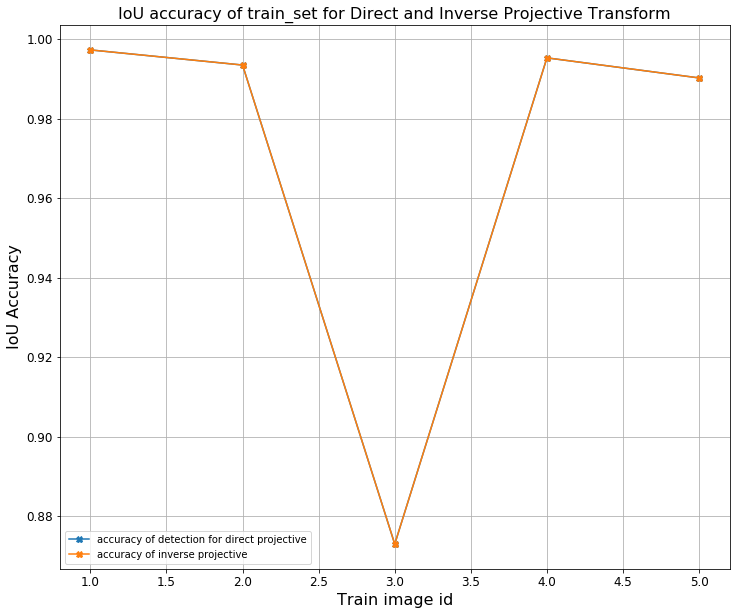

In [148]:
plt.figure(figsize=(12, 10))
plt.plot(1+np.arange(5),accdirect,marker='X',label='accuracy of detection for direct projective')
plt.plot(1+np.arange(5),accinverse,marker='X',label='accuracy of inverse projective')
plt.xlabel('Train image id',fontsize=16)
plt.ylabel('IoU Accuracy',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('IoU accuracy of train_set for Direct and Inverse Projective Transform',fontsize=16)
plt.grid()
plt.legend()

In [154]:
accdirect_test=[]
accinverse_test=[]
for strin in test_images:
    im=cv.imread('Desktop/dataset/orig/'+strin)
    mask=cv.imread('Desktop/dataset/masks/'+strin[0:7]+'.png')
    a1,a2=extractpainting(im,mask)
    accdirect_test.append(a1)
    accinverse_test.append(a2)

0
0
0
0
0
0
0
0
0
0


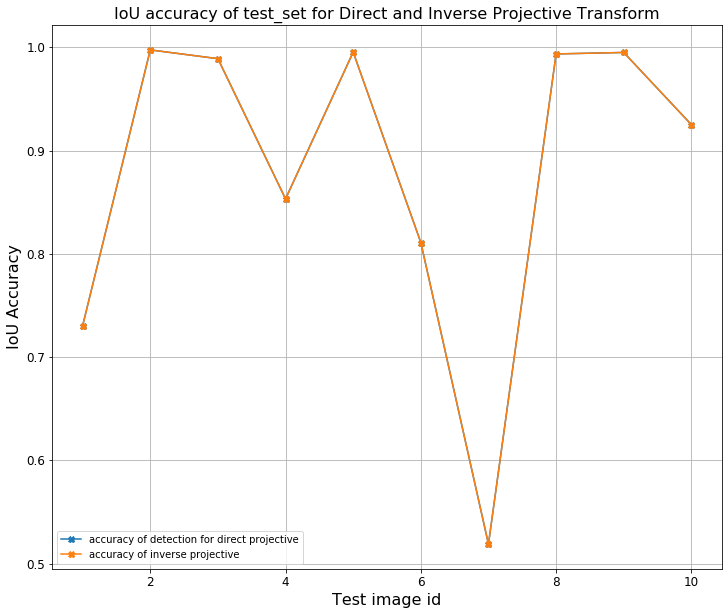

In [156]:
plt.figure(figsize=(12, 10))
plt.plot(1+np.arange(10),accdirect_test,marker='X',label='accuracy of detection for direct projective')
plt.plot(1+np.arange(10),accinverse_test,marker='X',label='accuracy of inverse projective')
plt.xlabel('Test image id',fontsize=16)
plt.ylabel('IoU Accuracy',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('IoU accuracy of test_set for Direct and Inverse Projective Transform',fontsize=16)
plt.grid()
plt.legend()

In [157]:
accdirect=np.array(accdirect)
accinverse=np.array(accinverse)
accdirect_test=np.array(accdirect_test)
accinverse_test=np.array(accinverse_test)

In [158]:
print('average training IoU direct', accdirect.sum()/5)
print('average training IoU inverse', accinverse.sum()/5)
print('average test IoU direct', accdirect_test.sum()/10)
print('average test IoU inverse', accinverse_test.sum()/10)

average training IoU direct 0.9698555946350098
average training IoU inverse 0.9698555946350098
average test IoU direct 0.8808955192565918
average test IoU inverse 0.8808955192565918


In [160]:
\